# Preparing Alpha Factors and Features to predict Stock Returns

## Imports & Settings

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import pearsonr, spearmanr
from talib import RSI, BBANDS, MACD, ATR

In [3]:
MONTH = 21
YEAR = 12 * MONTH

In [4]:
START = '2013-01-01'
END = '2017-12-31'

In [5]:
sns.set_style('whitegrid')
idx = pd.IndexSlice

## Loading Quandl Wiki Stock Prices & Meta Data

In [6]:
ohlcv = ['adj_open', 'adj_close', 'adj_low', 'adj_high', 'adj_volume']

In [7]:
DATA_STORE = '../data/assets.h5'

In [8]:
with pd.HDFStore(DATA_STORE) as store:
    prices = (store['quandl/wiki/prices']
              .loc[idx[START:END, :], ohlcv]
              .rename(columns=lambda x: x.replace('adj_', ''))
              .assign(volume=lambda x: x.volume.div(1000))
              .swaplevel()
              .sort_index())

    stocks = (store['us_equities/stocks']
              .loc[:, ['marketcap', 'ipoyear', 'sector']])
#此处的prices对应的是日频数据

In [9]:
prices

open      close        low       high    volume
ticker date                                                            
A      2013-01-02  29.054711  28.854904  28.351942  29.054711  6287.700
       2013-01-03  28.896244  28.958253  28.648276  29.034042  4114.300
       2013-01-04  29.034042  29.530115  28.841124  29.592124  4601.500
       2013-01-07  29.350977  29.316528  29.199399  29.488775  2567.600
       2013-01-08  29.261408  29.082271  29.006482  29.474995  2787.500
...                      ...        ...        ...        ...       ...
ZUMZ   2017-12-22  21.550000  21.450000  21.300000  21.700000   209.585
       2017-12-26  21.450000  21.850000  21.450000  22.200000   213.951
       2017-12-27  21.800000  21.150000  20.950000  22.250000   227.325
       2017-12-28  21.200000  21.200000  21.050000  21.450000   162.070
       2017-12-29  21.250000  20.825000  20.800000  21.450000   222.040

[3619403 rows x 5 columns]

In [10]:
stocks

,marketcap,ipoyear,sector
ticker,,,
PIH,4.309000e+07,2014.0,Finance
PIHPP,NaN,NaN,Finance
TURN,7.033000e+07,NaN,Finance
FLWS,8.333900e+08,1999.0,Consumer Services
FCCY,1.781400e+08,NaN,Finance
...,...,...,...
ZOES,1.974000e+08,2014.0,Consumer Services
ZTS,4.165000e+10,2013.0,Health Care
ZTO,1.434000e+10,2016.0,Transportation


## Remove stocks with few observations

In [11]:
# want at least 2 years of data
min_obs = 2 * YEAR

# have this much per ticker 
nobs = prices.groupby(level='ticker').size() #size计数时包含NaN值，而count不包含NaN值 #nobs为ticker所对应的个数

# keep those that exceed the limit
keep = nobs[nobs > min_obs].index #筛选出至少有两年数据的股票的ticker

prices = prices.loc[idx[keep, :], :]

In [19]:
prices

open      close        low       high    volume
ticker date                                                            
A      2013-01-02  29.054711  28.854904  28.351942  29.054711  6287.700
       2013-01-03  28.896244  28.958253  28.648276  29.034042  4114.300
       2013-01-04  29.034042  29.530115  28.841124  29.592124  4601.500
       2013-01-07  29.350977  29.316528  29.199399  29.488775  2567.600
       2013-01-08  29.261408  29.082271  29.006482  29.474995  2787.500
...                      ...        ...        ...        ...       ...
ZUMZ   2017-12-22  21.550000  21.450000  21.300000  21.700000   209.585
       2017-12-26  21.450000  21.850000  21.450000  22.200000   213.951
       2017-12-27  21.800000  21.150000  20.950000  22.250000   227.325
       2017-12-28  21.200000  21.200000  21.050000  21.450000   162.070
       2017-12-29  21.250000  20.825000  20.800000  21.450000   222.040

[3566454 rows x 5 columns]

### Align price and meta data

In [21]:
stocks = stocks[~stocks.index.duplicated() & stocks.sector.notnull()] #取非重复值与非空值
stocks.sector = stocks.sector.str.lower().str.replace(' ', '_') #把sector中大写字母转换为小写，并将 替换为_
stocks.index.name = 'ticker' #更改index的name

In [22]:
shared = (prices.index.get_level_values('ticker').unique() #get_level_values()取子目录
          .intersection(stocks.index)) #求prices与stocks中index的交集
stocks = stocks.loc[shared, :]
prices = prices.loc[idx[shared, :], :]

In [25]:
prices.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2904233 entries, ('A', Timestamp('2013-01-02 00:00:00')) to ('ZUMZ', Timestamp('2017-12-29 00:00:00'))
Data columns (total 5 columns):
 #   Column  Non-Null Count    Dtype  
---  ------  --------------    -----  
 0   open    2904233 non-null  float64
 1   close   2904233 non-null  float64
 2   low     2904233 non-null  float64
 3   high    2904233 non-null  float64
 4   volume  2904233 non-null  float64
dtypes: float64(5)
memory usage: 122.6+ MB


In [26]:
stocks.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Index: 2348 entries, A to ZUMZ
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   marketcap  2345 non-null   float64
 1   ipoyear    1026 non-null   float64
 2   sector     2348 non-null   object 
dtypes: float64(2), object(1)
memory usage: 73.4+ KB


In [27]:
stocks.sector.value_counts()

consumer_services        440
finance                  393
technology               297
health_care              297
capital_goods            227
basic_industries         138
consumer_non-durables    126
energy                   123
public_utilities         105
consumer_durables         78
miscellaneous             69
transportation            55
Name: sector, dtype: int64

Optional: persist intermediate results:

In [39]:
#保存
with pd.HDFStore('tmp.h5') as store:
    store.put('prices', prices)
    store.put('stocks', stocks)

In [115]:
#读取
with pd.HDFStore('tmp.h5') as store:
    prices = store['prices']
    stocks = store['stocks']

## Compute Rolling Average Dollar Volume

In [116]:
# compute dollar volume to determine universe #dollar volume 现金交易量
prices['dollar_vol'] = prices[['close', 'volume']].prod(axis=1) #prod()连乘

In [117]:
prices['dollar_vol_1m'] = (prices.dollar_vol.groupby('ticker')
                           .rolling(window=21, level='date')
                           .mean()).values #以月为窗口求均值

In [118]:
prices.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2904233 entries, ('A', Timestamp('2013-01-02 00:00:00')) to ('ZUMZ', Timestamp('2017-12-29 00:00:00'))
Data columns (total 7 columns):
 #   Column         Non-Null Count    Dtype  
---  ------         --------------    -----  
 0   open           2904233 non-null  float64
 1   close          2904233 non-null  float64
 2   low            2904233 non-null  float64
 3   high           2904233 non-null  float64
 4   volume         2904233 non-null  float64
 5   dollar_vol     2904233 non-null  float64
 6   dollar_vol_1m  2857273 non-null  float64
dtypes: float64(7)
memory usage: 166.9+ MB


In [119]:
prices.index.get_level_values('ticker').unique()

Index(['A', 'AAL', 'AAMC', 'AAN', 'AAOI', 'AAON', 'AAP', 'AAPL', 'AAT', 'AAWW',
       ...
       'ZEN', 'ZEUS', 'ZGNX', 'ZION', 'ZIOP', 'ZIXI', 'ZNGA', 'ZOES', 'ZTS',
       'ZUMZ'],
      dtype='object', name='ticker', length=2348)

In [120]:
2348*(21-1) == 2904233-2857273

True

In [121]:
prices['dollar_vol_rank'] = (prices.groupby('date') 
                             .dollar_vol_1m #在每个交易日，对dollar_vol_lm赋予排序
                             .rank(ascending=False)) #按降序返回数据排列

In [122]:
prices.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2904233 entries, ('A', Timestamp('2013-01-02 00:00:00')) to ('ZUMZ', Timestamp('2017-12-29 00:00:00'))
Data columns (total 8 columns):
 #   Column           Non-Null Count    Dtype  
---  ------           --------------    -----  
 0   open             2904233 non-null  float64
 1   close            2904233 non-null  float64
 2   low              2904233 non-null  float64
 3   high             2904233 non-null  float64
 4   volume           2904233 non-null  float64
 5   dollar_vol       2904233 non-null  float64
 6   dollar_vol_1m    2857273 non-null  float64
 7   dollar_vol_rank  2857273 non-null  float64
dtypes: float64(8)
memory usage: 189.1+ MB


In [123]:
prices

open      close        low       high    volume  \
ticker date                                                               
A      2013-01-02  29.054711  28.854904  28.351942  29.054711  6287.700   
       2013-01-03  28.896244  28.958253  28.648276  29.034042  4114.300   
       2013-01-04  29.034042  29.530115  28.841124  29.592124  4601.500   
       2013-01-07  29.350977  29.316528  29.199399  29.488775  2567.600   
       2013-01-08  29.261408  29.082271  29.006482  29.474995  2787.500   
...                      ...        ...        ...        ...       ...   
ZUMZ   2017-12-22  21.550000  21.450000  21.300000  21.700000   209.585   
       2017-12-26  21.450000  21.850000  21.450000  22.200000   213.951   
       2017-12-27  21.800000  21.150000  20.950000  22.250000   227.325   
       2017-12-28  21.200000  21.200000  21.050000  21.450000   162.070   
       2017-12-29  21.250000  20.825000  20.800000  21.450000   222.040   

                      dollar_vol  dollar_vol_1m  dollar_vol_rank  
ticker date                                                       
A      2013-01-02  181430.981611            NaN              NaN  
       2013-01-03  119142.939438            NaN              NaN  
       2013-01-04  135882.822089            NaN              NaN  
       2013-01-07   75273.116328            NaN              NaN  
       2013-01-08   81066.830411            NaN              NaN  
...                          ...            ...              ...  
ZUMZ   2017-12-22    4495.598250   11930.001226           1288.0  
       2017-12-26    4674.829350   11963.373076           1291.0  
       2017-12-27    4807.923750   11786.938512           1293.0  
       2017-12-28    3435.884000   11290.208650           1300.0  
       2017-12-29    4623.983000   10790.612631           1312.0  

[2904233 rows x 8 columns]

## Add some Basic Factors

### Compute the Relative Strength Index

In [124]:
# 相对强弱指标，值在0-100之间 #反映市场或股票的走势，高于50时定义为强，反之为弱
prices['rsi'] = prices.groupby(level='ticker').close.apply(RSI)

In [125]:
prices

open      close        low       high    volume  \
ticker date                                                               
A      2013-01-02  29.054711  28.854904  28.351942  29.054711  6287.700   
       2013-01-03  28.896244  28.958253  28.648276  29.034042  4114.300   
       2013-01-04  29.034042  29.530115  28.841124  29.592124  4601.500   
       2013-01-07  29.350977  29.316528  29.199399  29.488775  2567.600   
       2013-01-08  29.261408  29.082271  29.006482  29.474995  2787.500   
...                      ...        ...        ...        ...       ...   
ZUMZ   2017-12-22  21.550000  21.450000  21.300000  21.700000   209.585   
       2017-12-26  21.450000  21.850000  21.450000  22.200000   213.951   
       2017-12-27  21.800000  21.150000  20.950000  22.250000   227.325   
       2017-12-28  21.200000  21.200000  21.050000  21.450000   162.070   
       2017-12-29  21.250000  20.825000  20.800000  21.450000   222.040   

                      dollar_vol  dollar_vol_1m  dollar_vol_rank        rsi  
ticker date                                                                  
A      2013-01-02  181430.981611            NaN              NaN        NaN  
       2013-01-03  119142.939438            NaN              NaN        NaN  
       2013-01-04  135882.822089            NaN              NaN        NaN  
       2013-01-07   75273.116328            NaN              NaN        NaN  
       2013-01-08   81066.830411            NaN              NaN        NaN  
...                          ...            ...              ...        ...  
ZUMZ   2017-12-22    4495.598250   11930.001226           1288.0  61.077094  
       2017-12-26    4674.829350   11963.373076           1291.0  63.799097  
       2017-12-27    4807.923750   11786.938512           1293.0  56.369727  
       2017-12-28    3435.884000   11290.208650           1300.0  56.757082  
       2017-12-29    4623.983000   10790.612631           1312.0  52.959469  

[2904233 rows x 9 columns]

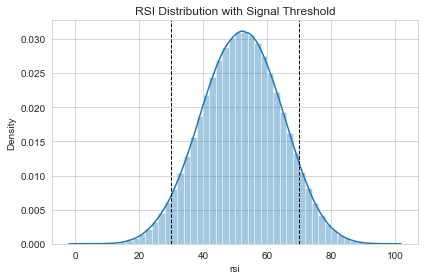

In [126]:
ax = sns.distplot(prices.rsi.dropna()) #绘制直方图与密度图
ax.axvline(30, ls='--', lw=1, c='k') #绘制垂直线
ax.axvline(70, ls='--', lw=1, c='k')
ax.set_title('RSI Distribution with Signal Threshold')
plt.tight_layout();

### Compute Bollinger Bands

In [127]:
def compute_bb(close):
    high, mid, low = BBANDS(close, timeperiod=20)
    return pd.DataFrame({'bb_high': high, 'bb_low': low}, index=close.index)

In [128]:
prices = (prices.join(prices
                      .groupby(level='ticker')
                      .close
                      .apply(compute_bb)))

In [129]:
prices

open      close        low       high    volume  \
ticker date                                                               
A      2013-01-02  29.054711  28.854904  28.351942  29.054711  6287.700   
       2013-01-03  28.896244  28.958253  28.648276  29.034042  4114.300   
       2013-01-04  29.034042  29.530115  28.841124  29.592124  4601.500   
       2013-01-07  29.350977  29.316528  29.199399  29.488775  2567.600   
       2013-01-08  29.261408  29.082271  29.006482  29.474995  2787.500   
...                      ...        ...        ...        ...       ...   
ZUMZ   2017-12-22  21.550000  21.450000  21.300000  21.700000   209.585   
       2017-12-26  21.450000  21.850000  21.450000  22.200000   213.951   
       2017-12-27  21.800000  21.150000  20.950000  22.250000   227.325   
       2017-12-28  21.200000  21.200000  21.050000  21.450000   162.070   
       2017-12-29  21.250000  20.825000  20.800000  21.450000   222.040   

                      dollar_vol  dollar_vol_1m  dollar_vol_rank        rsi  \
ticker date                                                                   
A      2013-01-02  181430.981611            NaN              NaN        NaN   
       2013-01-03  119142.939438            NaN              NaN        NaN   
       2013-01-04  135882.822089            NaN              NaN        NaN   
       2013-01-07   75273.116328            NaN              NaN        NaN   
       2013-01-08   81066.830411            NaN              NaN        NaN   
...                          ...            ...              ...        ...   
ZUMZ   2017-12-22    4495.598250   11930.001226           1288.0  61.077094   
       2017-12-26    4674.829350   11963.373076           1291.0  63.799097   
       2017-12-27    4807.923750   11786.938512           1293.0  56.369727   
       2017-12-28    3435.884000   11290.208650           1300.0  56.757082   
       2017-12-29    4623.983000   10790.612631           1312.0  52.959469   

                     bb_high     bb_low  
ticker date                              
A      2013-01-02        NaN        NaN  
       2013-01-03        NaN        NaN  
       2013-01-04        NaN        NaN  
       2013-01-07        NaN        NaN  
       2013-01-08        NaN        NaN  
...                      ...        ...  
ZUMZ   2017-12-22  22.086859  19.503141  
       2017-12-26  22.073133  19.781867  
       2017-12-27  22.063697  19.896303  
       2017-12-28  22.083536  19.911464  
       2017-12-29  21.972038  19.925462  

[2904233 rows x 11 columns]

In [130]:
prices['bb_high'] = prices.bb_high.sub(prices.close).div(prices.bb_high).apply(np.log1p) #np.log1p将数据压缩到一个区间
prices['bb_low'] = prices.close.sub(prices.bb_low).div(prices.close).apply(np.log1p)
#对带的偏离比例进行标准化处理

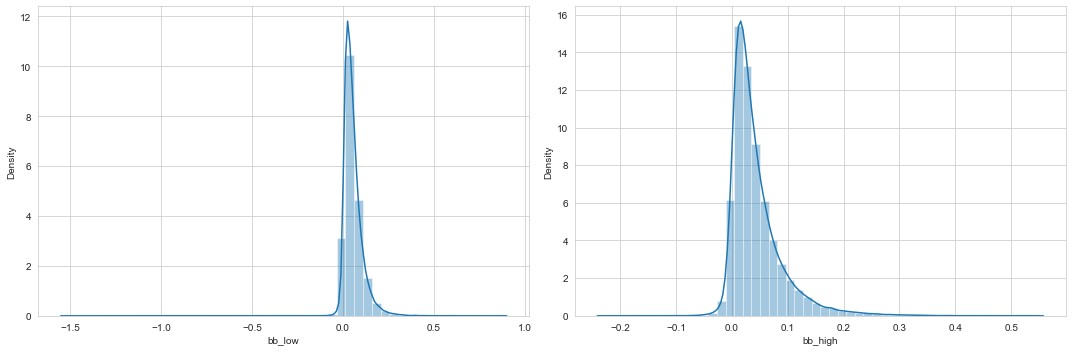

In [131]:
fig, axes = plt.subplots(ncols=2, figsize=(15, 5))
sns.distplot(prices.loc[prices.dollar_vol_rank<100, 'bb_low'].dropna(), ax=axes[0])
sns.distplot(prices.loc[prices.dollar_vol_rank<100, 'bb_high'].dropna(), ax=axes[1])
plt.tight_layout();

### Compute Average True Range

In [132]:
#计算平均真实波幅
def compute_atr(stock_data):
    df = ATR(stock_data.high, stock_data.low, 
             stock_data.close, timeperiod=14)
    return df.sub(df.mean()).div(df.std())

In [133]:
prices['atr'] = (prices.groupby('ticker', group_keys=False)
                 .apply(compute_atr))

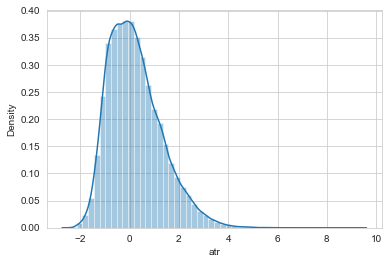

In [134]:
sns.distplot(prices[prices.dollar_vol_rank<50].atr.dropna());

### Compute Moving Average Convergence/Divergence

In [135]:
def compute_macd(close):
    macd = MACD(close)[0] #取DIF值
    return (macd - np.mean(macd))/np.std(macd) #标准化

In [136]:
prices['macd'] = (prices
                  .groupby('ticker', group_keys=False)
                  .close
                  .apply(compute_macd))

In [137]:
prices.macd.describe(percentiles=[.001, .01, .02, .03, .04, .05, .95, .96, .97, .98, .99, .999]).apply(lambda x: f'{x:,.1f}')

count    2,826,749.0
mean            -0.0
std              1.0
min            -10.5
0.1%            -4.1
1%              -2.6
2%              -2.2
3%              -2.0
4%              -1.8
5%              -1.6
50%              0.0
95%              1.6
96%              1.7
97%              1.9
98%              2.1
99%              2.6
99.9%            4.0
max              8.7
Name: macd, dtype: object

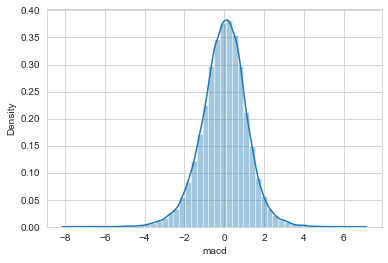

In [138]:
sns.distplot(prices[prices.dollar_vol_rank<100].macd.dropna());

## Compute Lagged Returns

In [139]:
lags = [1, 5, 10, 21, 42, 63]

In [140]:
returns = prices.groupby(level='ticker').close.pct_change() #计算收盘价的增长率 #!!!当期收盘价的经过pct得到的增长率其实对应的是当期的收益率
percentiles=[.0001, .001, .01]
percentiles+= [1-p for p in percentiles]
returns.describe(percentiles=percentiles).iloc[2:].to_frame('percentiles').style.format(lambda x: f'{x:,.2%}')

,percentiles
std,9.37%
min,-87.62%
0.01%,-33.40%
0.1%,-14.78%
1%,-6.52%
50%,0.04%
99%,6.98%
99.9%,17.03%
99.99%,39.25%
max,"10,280.40%"


In [141]:
q = 0.0001

### Winsorize outliers

In [142]:
#用winsorize的方法处理离群值
for lag in lags:
    prices[f'return_{lag}d'] = (prices.groupby(level='ticker').close
                                .pct_change(lag) #求当前元素与lag数前的元素的变化百分比
                                .pipe(lambda x: x.clip(lower=x.quantile(q),
                                                       upper=x.quantile(1 - q))) #winsorize缩尾,返回[1%,99%]排位的数据
                                .add(1)
                                .pow(1 / lag) #开根
                                .sub(1)
                                ) #得到的是收益率的日化值

In [143]:
prices

open      close        low       high    volume  \
ticker date                                                               
A      2013-01-02  29.054711  28.854904  28.351942  29.054711  6287.700   
       2013-01-03  28.896244  28.958253  28.648276  29.034042  4114.300   
       2013-01-04  29.034042  29.530115  28.841124  29.592124  4601.500   
       2013-01-07  29.350977  29.316528  29.199399  29.488775  2567.600   
       2013-01-08  29.261408  29.082271  29.006482  29.474995  2787.500   
...                      ...        ...        ...        ...       ...   
ZUMZ   2017-12-22  21.550000  21.450000  21.300000  21.700000   209.585   
       2017-12-26  21.450000  21.850000  21.450000  22.200000   213.951   
       2017-12-27  21.800000  21.150000  20.950000  22.250000   227.325   
       2017-12-28  21.200000  21.200000  21.050000  21.450000   162.070   
       2017-12-29  21.250000  20.825000  20.800000  21.450000   222.040   

                      dollar_vol  dollar_vol_1m  dollar_vol_rank        rsi  \
ticker date                                                                   
A      2013-01-02  181430.981611            NaN              NaN        NaN   
       2013-01-03  119142.939438            NaN              NaN        NaN   
       2013-01-04  135882.822089            NaN              NaN        NaN   
       2013-01-07   75273.116328            NaN              NaN        NaN   
       2013-01-08   81066.830411            NaN              NaN        NaN   
...                          ...            ...              ...        ...   
ZUMZ   2017-12-22    4495.598250   11930.001226           1288.0  61.077094   
       2017-12-26    4674.829350   11963.373076           1291.0  63.799097   
       2017-12-27    4807.923750   11786.938512           1293.0  56.369727   
       2017-12-28    3435.884000   11290.208650           1300.0  56.757082   
       2017-12-29    4623.983000   10790.612631           1312.0  52.959469   

                    bb_high    bb_low       atr      macd  return_1d  \
ticker date                                                            
A      2013-01-02       NaN       NaN       NaN       NaN        NaN   
       2013-01-03       NaN       NaN       NaN       NaN   0.003582   
       2013-01-04       NaN       NaN       NaN       NaN   0.019748   
       2013-01-07       NaN       NaN       NaN       NaN  -0.007233   
       2013-01-08       NaN       NaN       NaN       NaN  -0.007991   
...                     ...       ...       ...       ...        ...   
ZUMZ   2017-12-22  0.028426  0.086877 -0.419131  0.851425  -0.002326   
       2017-12-26  0.010058  0.090436 -0.450751  0.889373   0.018648   
       2017-12-27  0.040577  0.057586 -0.282948  0.832724  -0.032037   
       2017-12-28  0.039229  0.059005 -0.449763  0.784419   0.002364   
       2017-12-29  0.050887  0.042288 -0.515043  0.696842  -0.017689   

                   return_5d  return_10d  return_21d  return_42d  return_63d  
ticker date                                                                   
A      2013-01-02        NaN         NaN         NaN         NaN         NaN  
       2013-01-03        NaN         NaN         NaN         NaN         NaN  
       2013-01-04        NaN         NaN         NaN         NaN         NaN  
       2013-01-07        NaN         NaN         NaN         NaN         NaN  
       2013-01-08        NaN         NaN         NaN         NaN         NaN  
...                      ...         ...         ...         ...         ...  
ZUMZ   2017-12-22   0.013086    0.001173    0.006812    0.004653    0.004222  
       2017-12-26   0.005112    0.004215    0.006552    0.004759    0.004086  
       2017-12-27  -0.000472    0.002882    0.004617    0.003781    0.003757  
       2017-12-28   0.000000    0.004100    0.002540    0.003249    0.002958  
       2017-12-29  -0.006359    0.004050   -0.000057    0.003544    0.002674  

[2904233 rows x 19 columns]

### Shift lagged returns

In [144]:
for t in [1, 2, 3, 4, 5]:
    for lag in [1, 5, 10, 21]:
        prices[f'return_{lag}d_lag{t}'] = (prices.groupby(level='ticker')
                                           [f'return_{lag}d'].shift(t * lag)) #所有数据向下偏移t*lag行

In [145]:
prices

open      close        low       high    volume  \
ticker date                                                               
A      2013-01-02  29.054711  28.854904  28.351942  29.054711  6287.700   
       2013-01-03  28.896244  28.958253  28.648276  29.034042  4114.300   
       2013-01-04  29.034042  29.530115  28.841124  29.592124  4601.500   
       2013-01-07  29.350977  29.316528  29.199399  29.488775  2567.600   
       2013-01-08  29.261408  29.082271  29.006482  29.474995  2787.500   
...                      ...        ...        ...        ...       ...   
ZUMZ   2017-12-22  21.550000  21.450000  21.300000  21.700000   209.585   
       2017-12-26  21.450000  21.850000  21.450000  22.200000   213.951   
       2017-12-27  21.800000  21.150000  20.950000  22.250000   227.325   
       2017-12-28  21.200000  21.200000  21.050000  21.450000   162.070   
       2017-12-29  21.250000  20.825000  20.800000  21.450000   222.040   

                      dollar_vol  dollar_vol_1m  dollar_vol_rank        rsi  \
ticker date                                                                   
A      2013-01-02  181430.981611            NaN              NaN        NaN   
       2013-01-03  119142.939438            NaN              NaN        NaN   
       2013-01-04  135882.822089            NaN              NaN        NaN   
       2013-01-07   75273.116328            NaN              NaN        NaN   
       2013-01-08   81066.830411            NaN              NaN        NaN   
...                          ...            ...              ...        ...   
ZUMZ   2017-12-22    4495.598250   11930.001226           1288.0  61.077094   
       2017-12-26    4674.829350   11963.373076           1291.0  63.799097   
       2017-12-27    4807.923750   11786.938512           1293.0  56.369727   
       2017-12-28    3435.884000   11290.208650           1300.0  56.757082   
       2017-12-29    4623.983000   10790.612631           1312.0  52.959469   

                    bb_high  ...  return_10d_lag3  return_21d_lag3  \
ticker date                  ...                                     
A      2013-01-02       NaN  ...              NaN              NaN   
       2013-01-03       NaN  ...              NaN              NaN   
       2013-01-04       NaN  ...              NaN              NaN   
       2013-01-07       NaN  ...              NaN              NaN   
       2013-01-08       NaN  ...              NaN              NaN   
...                     ...  ...              ...              ...   
ZUMZ   2017-12-22  0.028426  ...         0.000553         0.014335   
       2017-12-26  0.010058  ...         0.002141         0.012572   
       2017-12-27  0.040577  ...         0.002479         0.010359   
       2017-12-28  0.039229  ...         0.001711         0.014717   
       2017-12-29  0.050887  ...         0.001407         0.014531   

                   return_1d_lag4  return_5d_lag4  return_10d_lag4  \
ticker date                                                          
A      2013-01-02             NaN             NaN              NaN   
       2013-01-03             NaN             NaN              NaN   
       2013-01-04             NaN             NaN              NaN   
       2013-01-07             NaN             NaN              NaN   
       2013-01-08             NaN             NaN              NaN   
...                           ...             ...              ...   
ZUMZ   2017-12-22        0.059701        0.008066        -0.001101   
       2017-12-26       -0.004695        0.003155         0.005860   
       2017-12-27        0.000000        0.007634         0.004570   
       2017-12-28        0.014151        0.015044         0.002624   
       2017-12-29       -0.002326        0.032259         0.003759   

                   return_21d_lag4  return_1d_lag5  return_5d_lag5  \
ticker date                                                          
A      2013-01-02              NaN             NaN        

## Compute Forward Returns

In [146]:
for t in [1, 5, 10, 21]:
    prices[f'target_{t}d'] = prices.groupby(level='ticker')[f'return_{t}d'].shift(-t) #!!!将当期收益率上移，可构建未来收益率序列

In [147]:
prices #!!target_td表示的是日化的t天收益率数据，收益率与日期是相匹配的，即20xx/12/xx对应的收益率就是当日的收益率

open      close        low       high    volume  \
ticker date                                                               
A      2013-01-02  29.054711  28.854904  28.351942  29.054711  6287.700   
       2013-01-03  28.896244  28.958253  28.648276  29.034042  4114.300   
       2013-01-04  29.034042  29.530115  28.841124  29.592124  4601.500   
       2013-01-07  29.350977  29.316528  29.199399  29.488775  2567.600   
       2013-01-08  29.261408  29.082271  29.006482  29.474995  2787.500   
...                      ...        ...        ...        ...       ...   
ZUMZ   2017-12-22  21.550000  21.450000  21.300000  21.700000   209.585   
       2017-12-26  21.450000  21.850000  21.450000  22.200000   213.951   
       2017-12-27  21.800000  21.150000  20.950000  22.250000   227.325   
       2017-12-28  21.200000  21.200000  21.050000  21.450000   162.070   
       2017-12-29  21.250000  20.825000  20.800000  21.450000   222.040   

                      dollar_vol  dollar_vol_1m  dollar_vol_rank        rsi  \
ticker date                                                                   
A      2013-01-02  181430.981611            NaN              NaN        NaN   
       2013-01-03  119142.939438            NaN              NaN        NaN   
       2013-01-04  135882.822089            NaN              NaN        NaN   
       2013-01-07   75273.116328            NaN              NaN        NaN   
       2013-01-08   81066.830411            NaN              NaN        NaN   
...                          ...            ...              ...        ...   
ZUMZ   2017-12-22    4495.598250   11930.001226           1288.0  61.077094   
       2017-12-26    4674.829350   11963.373076           1291.0  63.799097   
       2017-12-27    4807.923750   11786.938512           1293.0  56.369727   
       2017-12-28    3435.884000   11290.208650           1300.0  56.757082   
       2017-12-29    4623.983000   10790.612631           1312.0  52.959469   

                    bb_high  ...  return_10d_lag4  return_21d_lag4  \
ticker date                  ...                                     
A      2013-01-02       NaN  ...              NaN              NaN   
       2013-01-03       NaN  ...              NaN              NaN   
       2013-01-04       NaN  ...              NaN              NaN   
       2013-01-07       NaN  ...              NaN              NaN   
       2013-01-08       NaN  ...              NaN              NaN   
...                     ...  ...              ...              ...   
ZUMZ   2017-12-22  0.028426  ...        -0.001101        -0.000389   
       2017-12-26  0.010058  ...         0.005860         0.002061   
       2017-12-27  0.040577  ...         0.004570         0.002362   
       2017-12-28  0.039229  ...         0.002624         0.002069   
       2017-12-29  0.050887  ...         0.003759         0.001112   

                   return_1d_lag5  return_5d_lag5  return_10d_lag5  \
ticker date                                                          
A      2013-01-02             NaN             NaN              NaN   
       2013-01-03             NaN             NaN              NaN   
       2013-01-04             NaN             NaN              NaN   
       2013-01-07             NaN             NaN              NaN   
       2013-01-08             NaN             NaN              NaN   
...                           ...             ...              ...   
ZUMZ   2017-12-22        0.005000        0.001647         0.003633   
       2017-12-26        0.059701        0.000000        -0.000856   
       2017-12-27       -0.004695        0.010119        -0.005377   
       2017-12-28        0.000000        0.017985        -0.008980   
       2017-12-29        0.014151        0.007702        -0.012096   

                   return_21d_lag5  target_1d  target_5d  target_10d  \
ticker date                                                            
A      2013-01-02              NaN   0.003582   0.0069

## Combine Price and Meta Data

In [91]:
prices = prices.join(stocks[['sector']])

In [1]:
prices

NameError: name 'prices' is not defined

## Create time and sector dummy variables

In [92]:
prices['year'] = prices.index.get_level_values('date').year
prices['month'] = prices.index.get_level_values('date').month

In [93]:
prices.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2904233 entries, ('A', Timestamp('2013-01-02 00:00:00')) to ('ZUMZ', Timestamp('2017-12-29 00:00:00'))
Data columns (total 46 columns):
 #   Column           Non-Null Count    Dtype  
---  ------           --------------    -----  
 0   open             2904233 non-null  float64
 1   close            2904233 non-null  float64
 2   low              2904233 non-null  float64
 3   high             2904233 non-null  float64
 4   volume           2904233 non-null  float64
 5   dollar_vol       2904233 non-null  float64
 6   dollar_vol_1m    2857273 non-null  float64
 7   dollar_vol_rank  2857273 non-null  float64
 8   rsi              2871361 non-null  float64
 9   bb_high          2859618 non-null  float64
 10  bb_low           2859585 non-null  float64
 11  atr              2871361 non-null  float64
 12  macd             2826749 non-null  float64
 13  return_1d        2901885 non-null  float64
 14  return_5d        2892493 non-null  float6

In [94]:
prices.assign(sector=pd.factorize(prices.sector, sort=True)[0]).to_hdf('data.h5', 'model_data/no_dummies') #将没有虚拟变量的数据储存起来

In [95]:
prices = pd.get_dummies(prices, #创建虚拟变量
                        columns=['year', 'month', 'sector'],
                        prefix=['year', 'month', ''], #给列名加前缀
                        prefix_sep=['_', '_', ''],
                        drop_first=True) #去除第一个，避免完全共线性

In [98]:
prices.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2904233 entries, ('A', Timestamp('2013-01-02 00:00:00')) to ('ZUMZ', Timestamp('2017-12-29 00:00:00'))
Data columns (total 69 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   open                   2904233 non-null  float64
 1   close                  2904233 non-null  float64
 2   low                    2904233 non-null  float64
 3   high                   2904233 non-null  float64
 4   volume                 2904233 non-null  float64
 5   dollar_vol             2904233 non-null  float64
 6   dollar_vol_1m          2857273 non-null  float64
 7   dollar_vol_rank        2857273 non-null  float64
 8   rsi                    2871361 non-null  float64
 9   bb_high                2859618 non-null  float64
 10  bb_low                 2859585 non-null  float64
 11  atr                    2871361 non-null  float64
 12  macd                   2826749 non-null  float64
 13 

## Store Model Data

In [99]:
prices.to_hdf('data.h5', 'model_data')

## Explore Data

### Plot Factors

In [100]:
target = 'target_5d'
top100 = prices[prices.dollar_vol_rank<100].copy()

### RSI

In [101]:
top100.loc[:, 'rsi_signal'] = pd.cut(top100.rsi, bins=[0, 30, 70, 100])

In [104]:
top100.groupby('rsi_signal')['target_5d'].describe()

,count,mean,std,min,25%,50%,75%,max
rsi_signal,,,,,,,,
"(0, 30]",4209.0,0.001126,0.010457,-0.067138,-0.003606,0.001051,0.006156,0.061889
"(30, 70]",107244.0,0.000446,0.007711,-0.170571,-0.003054,0.000650,0.004246,0.075653
"(70, 100]",10634.0,0.000018,0.006354,-0.087857,-0.002818,0.000145,0.003121,0.058570


### Bollinger Bands

-2.68% (0.00%)


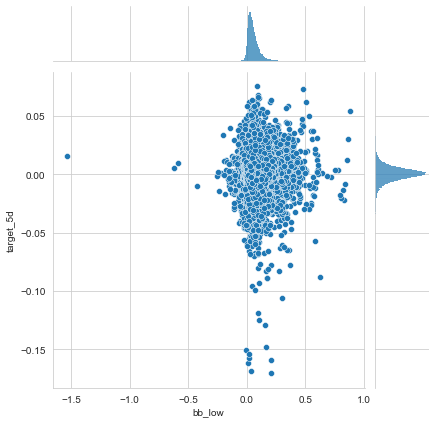

In [114]:
metric = 'bb_low'
j=sns.jointplot(x=metric, y=target, data=top100) #绘制双变量分布

df = top100[[metric, target]].dropna()
r, p = spearmanr(df[metric], df[target])
#斯皮尔曼相关系数（spearman's rank correlation coefficient, SCC）是衡量两变量之间的关系，无正态分布这一前提假设
#p：即p-value,其原假设是两组数据不相关
print(f'{r:,.2%} ({p:.2%})')

4.21% (0.00%)


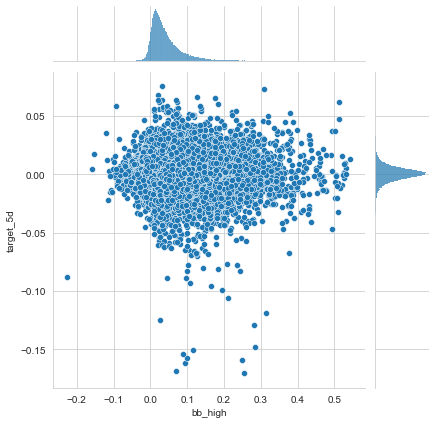

In [110]:
metric = 'bb_high'
j=sns.jointplot(x=metric, y=target, data=top100)

df = top100[[metric, target]].dropna()
r, p = spearmanr(df[metric], df[target])
print(f'{r:,.2%} ({p:.2%})')

### ATR

0.07% (80.08%)


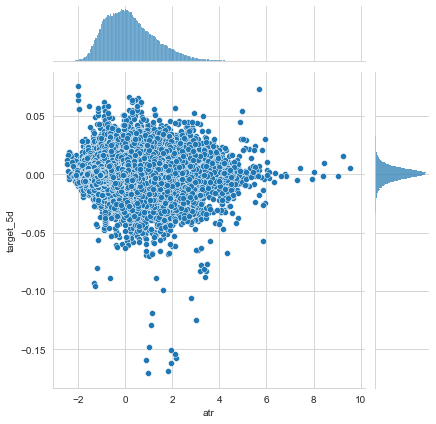

In [111]:
metric = 'atr'
j=sns.jointplot(x=metric, y=target, data=top100)

df = top100[[metric, target]].dropna()
r, p = spearmanr(df[metric], df[target])
print(f'{r:,.2%} ({p:.2%})')

### MACD

-4.72% (0.00%)


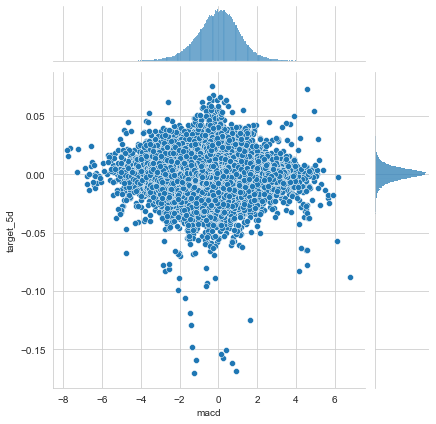

In [112]:
metric = 'macd'
j=sns.jointplot(x=metric, y=target, data=top100)

df = top100[[metric, target]].dropna()
r, p = spearmanr(df[metric], df[target])
print(f'{r:,.2%} ({p:.2%})')